# Librerias Utilizadas

In [8]:
import pandas as pd
from apyori import apriori
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, KBinsDiscretizer, StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from scipy.stats import bartlett
from factor_analyzer.factor_analyzer import calculate_kmo

# Lectura del .csv

In [10]:
df = pd.read_csv("movies_clean_scaled.csv", encoding="ISO-8859-1")

# Reglas de asociación

In [45]:
df.fillna({"productionCompanyCountry": "Desconocido", "productionCountry": "Desconocido", "originalLanguage": "Desconocido"}, inplace=True)

selector_num = make_column_selector(dtype_include=['int64', 'float64'])
selector_cat = make_column_selector(dtype_include=['object'])

variables_num = selector_num(df)
variables_cat = selector_cat(df)

preprocesador = ColumnTransformer(
    transformers=[
        ("num", KBinsDiscretizer(n_bins=5, encode="ordinal", strategy="uniform"), variables_num),
        ("cat", OneHotEncoder(sparse_output=False, drop="first"), variables_cat)
    ]
)

datos_transformados = preprocesador.fit_transform(df)

etiquetas_num_binarias = [f"{variables_num[i]}_bin{j}" for i in range(len(variables_num)) for j in range(5)]
etiquetas_cat_codificadas = preprocesador.named_transformers_["cat"].get_feature_names_out(variables_cat)

todas_etiquetas = etiquetas_num_binarias[:datos_transformados.shape[1] - len(etiquetas_cat_codificadas)] + list(etiquetas_cat_codificadas)

df_transformado = pd.DataFrame(datos_transformados, columns=todas_etiquetas)

transacciones = df_transformado.apply(lambda row: row[row == 1].index.tolist(), axis=1).tolist()

min_soporte = 0.05  
min_confianza = 0.6  
reglas = apriori(transacciones, min_support=min_soporte, min_confidence=min_confianza, min_lift=1.2, min_length=2)

lista_reglas = list(reglas)
reglas_asociacion = []

for regla in lista_reglas:
    for estadistica_ordenada in regla.ordered_statistics:
        reglas_asociacion.append({
            "Regla": f"{list(estadistica_ordenada.items_base)} → {list(estadistica_ordenada.items_add)}",
            "Soporte": regla.support,
            "Confianza": estadistica_ordenada.confidence,
            "Lift": estadistica_ordenada.lift 
        })

df_reglas = pd.DataFrame(reglas_asociacion)
print(df_reglas.head())

df_reglas.to_csv("reglas_asociacion.csv", index=False)

                                               Regla   Soporte  Confianza  \
0  ['productionCompanyCountry_US'] → ['originalLa...  0.101629   0.991579   
1  ['productionCompanyCountry_US|US'] → ['origina...  0.078433   1.000000   
2  ['originalLanguage_en'] → ['productionCountry_...  0.495846   0.638511   
3  ['productionCountry_United States of America']...  0.495846   0.998046   
4  ['originalLanguage_ja'] → ['productionCountry_...  0.061064   0.944908   

        Lift  
0   1.276875  
1   1.287719  
2   1.285202  
3   1.285202  
4  15.338623  


# PCA

Separacion de variables categoricas y numéricas

In [24]:
categorical_cols = ["productionCompanyCountry", "productionCountry", "originalLanguage"]
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()

Transformación de variables Categoricas

In [26]:
encoder = OneHotEncoder(sparse_output=False, drop="first")
encoded_cats = encoder.fit_transform(df[categorical_cols])
encoded_df = pd.DataFrame(encoded_cats, columns=encoder.get_feature_names_out())

if encoded_df.shape[1] > len(numerical_cols):
    print("Las variables categóricas aumentan significativamente la dimensionalidad, lo que puede no ser ideal para PCA.")


Las variables categóricas aumentan significativamente la dimensionalidad, lo que puede no ser ideal para PCA.


Selección y Normalización de Variables Numéricas

In [28]:
df_numeric = df[numerical_cols]

scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_numeric), columns=numerical_cols)


Evaluación de Viabilidad del PCA (KMO y Bartlett)

In [30]:
chi_square_value, p_value = bartlett(*df_scaled.T.values)
print(f"Test de Bartlett - Chi-cuadrado: {chi_square_value}, p-value: {p_value}")

# Índice KMO
kmo_all, kmo_model = calculate_kmo(df_scaled)
print(f"Índice KMO: {kmo_model}")

#PCA
if kmo_model < 0.6 or p_value > 0.05:
    print("PCA puede no ser adecuado debido a la baja adecuación de los datos.")
else:
    print("Los datos son adecuados para PCA.")

pca = PCA(n_components=len(numerical_cols))
principal_components = pca.fit_transform(df_scaled)

Test de Bartlett - Chi-cuadrado: 2.060493650239522e-12, p-value: 1.0
Índice KMO: 0.69762625431975
PCA puede no ser adecuado debido a la baja adecuación de los datos.


# Analisis de resultados:

Matriz de carga

In [38]:
loadings = pd.DataFrame(pca.components_.T, index=numerical_cols, columns=[f'PC{i+1}' for i in range(len(numerical_cols))])
print("Matriz de Carga:")
print(loadings)

Matriz de Carga:
                                PC1       PC2       PC3       PC4       PC5  \
budget                     0.506745  0.175555 -0.010610 -0.042685 -0.201308   
revenue                    0.534707  0.100202 -0.068037 -0.190377 -0.158713   
runtime                    0.287531 -0.344936  0.302138  0.043631  0.099083   
actorsPopularity           0.080064  0.445164 -0.202246  0.227418  0.231535   
popularity                 0.154201  0.249377 -0.066321 -0.130151  0.612250   
voteAvg                    0.185178 -0.417080 -0.085081  0.081198  0.583063   
voteCount                  0.517994 -0.010946 -0.037511 -0.154859 -0.091716   
genresAmount               0.143466  0.039910 -0.220046  0.749529  0.081731   
productionCoAmount         0.111502  0.117650  0.606239  0.431377 -0.035806   
productionCountriesAmount -0.039531  0.055810  0.432234 -0.297469  0.355591   
actorsAmount              -0.043711  0.171088 -0.411200 -0.145497  0.097781   
releaseYear               -0.073065

Matriz de Carga (Visual)

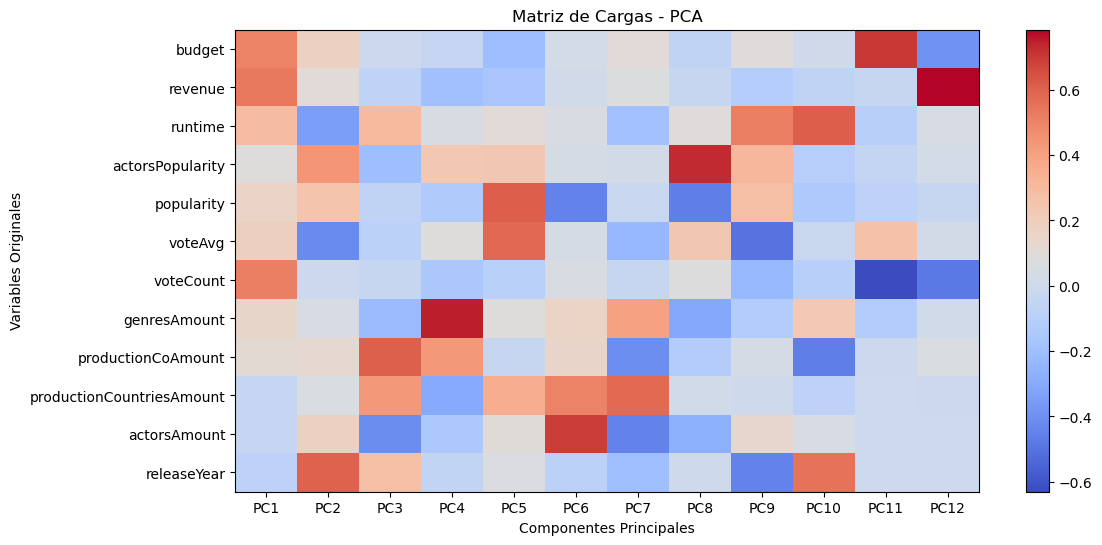

In [47]:

fig, ax = plt.subplots(figsize=(12, 6))
componentes = pca.components_
im = ax.imshow(componentes.T, cmap="coolwarm", aspect="auto")

# Etiquetas en los ejes
ax.set_yticks(range(len(numerical_cols)))
ax.set_yticklabels(numerical_cols)
ax.set_xticks(range(len(numerical_cols)))
ax.set_xticklabels([f"PC{i+1}" for i in range(len(numerical_cols))])

# Estilización
plt.xlabel("Componentes Principales")
plt.ylabel("Variables Originales")
plt.title("Matriz de Cargas - PCA")
plt.colorbar(im)
plt.show()

Screen Plot y Varianza Acumulada

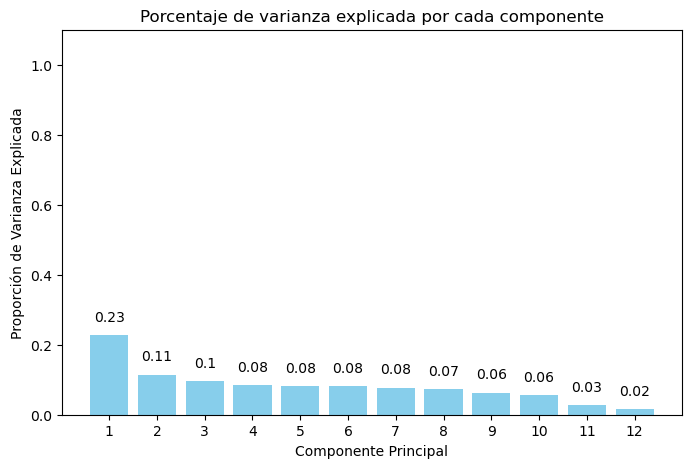

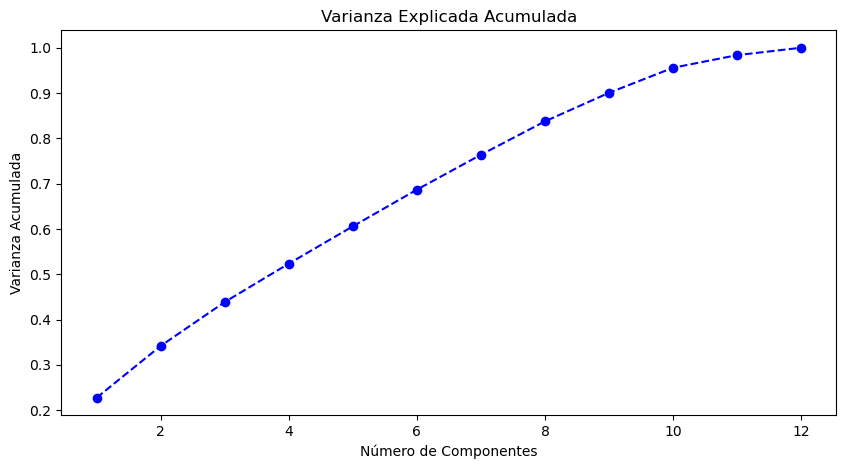

In [41]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 5))
ax.bar(
    x=np.arange(pca.n_components_) + 1,
    height=explained_variance,
    color='skyblue'
)

# Anotaciones en las barras
for x, y in zip(np.arange(len(numerical_cols)) + 1, explained_variance):
    label = round(y, 2)
    ax.annotate(
        label,
        (x, y),
        textcoords="offset points",
        xytext=(0, 10),
        ha='center'
    )

ax.set_xticks(np.arange(pca.n_components_) + 1)
ax.set_ylim(0, 1.1)
ax.set_title('Porcentaje de varianza explicada por cada componente')
ax.set_xlabel('Componente Principal')
ax.set_ylabel('Proporción de Varianza Explicada')
plt.show()

# **Gráfica de varianza acumulada**
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(numerical_cols) + 1), np.cumsum(explained_variance), marker='o', linestyle='--', color="b")
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Acumulada')
plt.title('Varianza Explicada Acumulada')
plt.show()